# 🧪 Expérimentations - Apprentissage par renforcement
Dans ce notebook, nous comparons plusieurs algorithmes (Monte Carlo, Q-Learning, Expected SARSA, Dyna-Q, Dyna-Q+)
sur les environnements secrets 

## Imports

In [3]:
import argparse
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# === Environnements ===
from secret_envs_wrapper import SecretEnv0, SecretEnv1, SecretEnv2, SecretEnv3

# === Algorithmes ===
from reinfolearn.algorithm.dp.policy_iteration import policy_iteration
from reinfolearn.algorithm.dp.value_iteration import value_iteration
from reinfolearn.algorithm.mc.mc_on_policy import mc_on_policy_first_visit
from reinfolearn.algorithm.mc.mc_off_policy import mc_off_policy_control
from reinfolearn.algorithm.mc.mc_exploring_starts import mc_exploring_starts
from reinfolearn.algorithm.td.q_learning import q_learning
from reinfolearn.algorithm.td.sarsa import sarsa
from reinfolearn.algorithm.td.expected_sarsa import expected_sarsa
from reinfolearn.algorithm.pn.dyna_q import dyna_q
from reinfolearn.algorithm.pn.dyna_q_plus import dyna_q_plus

# === Utilitaires ===
from reinfolearn.utils.io_utils import save_policy, save_q_table, save_values, save_scores
from reinfolearn.utils.plot_utils import plot_scores, plot_convergence
from reinfolearn.utils.metrics_utils import evaluate_policy_score, summarize_policy_scores

## Fonction utilitaire de visualisation

In [4]:
def plot_convergence(values, title="Convergence", ylabel="Value", save_path=None):
    plt.figure(figsize=(8, 4))
    plt.plot(values)
    plt.title(title)
    plt.xlabel("Itération")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Figure sauvegardée : {save_path}")
    plt.show()

def plot_scores(scores, title="Score par épisode", save_path=None):
    plt.figure(figsize=(8, 4))
    plt.plot(scores)
    plt.title(title)
    plt.xlabel("Épisode")
    plt.ylabel("Score total")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f" Figure sauvegardée : {save_path}")
    plt.show()


def plot_scores_mavg(scores, window=100, title="Score moyen"):
    moving_avg = np.convolve(scores, np.ones(window)/window, mode="valid")
    plt.figure(figsize=(8, 4))
    plt.plot(moving_avg)
    plt.title(title)
    plt.xlabel("Épisodes")
    plt.ylabel("Score moyen")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Fonction standard d'expérimentation

In [7]:
def get_env(env_name):
    envs = {
        "env0": SecretEnv0(),
        "env1": SecretEnv1(),
        "env2": SecretEnv2(),
        "env3": SecretEnv3(),
    }
    return envs[env_name]

## Informations utiles sur nos env secrets:

In [8]:

def display_env_info(env, env_name=""):
    print(f"== Environnement {env_name} ==")
    print(f"- Nombre d'états     : {env.num_states()}")
    print(f"- Nombre d'actions   : {env.num_actions()}")
    print(f"- Nombre de rewards  : {env.num_rewards()}")
    for i in range(env.num_rewards()):
        print(f"  - Reward[{i}] = {env.reward(i)}")
    print()

envs = {
    "SecretEnv0": SecretEnv0(),
    "SecretEnv1": SecretEnv1(),
    "SecretEnv2": SecretEnv2(),
    "SecretEnv3": SecretEnv3(),
}

for name, env in envs.items():
    display_env_info(env, name)


== Environnement SecretEnv0 ==
- Nombre d'états     : 8192
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv1 ==
- Nombre d'états     : 65536
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv2 ==
- Nombre d'états     : 2097152
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0

== Environnement SecretEnv3 ==
- Nombre d'états     : 65536
- Nombre d'actions   : 3
- Nombre de rewards  : 3
  - Reward[0] = -1.0
  - Reward[1] = 0.0
  - Reward[2] = 1.0



In [ ]:
def run_experiment(env_class, algo_fn, algo_name, env_name, **kwargs):
    env = env_class()

    # create output directory if it doesn't exist
    output_dir = f"outputs/{env_name}/{algo_name}"
    os.makedirs(output_dir, exist_ok=True)

    if algo_name == "policy_iteration":
        policy, V, mean_value_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for policy iteration
        save_scores(mean_value_history, f"{output_dir}/value_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, mean_value_history
    elif algo_name == "value_iteration":
        policy, V, delta_history = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_values(V, f"{output_dir}/values.npy") # Save values for value iteration
        save_scores(delta_history, f"{output_dir}/delta_convergence.npy")

        print(f"Politique et valeurs sauvegardées pour {env_name} avec {algo_name}")
        return policy, V, delta_history
    else:
        policy, Q, scores = algo_fn(env, **kwargs)
        save_policy(policy, f"{output_dir}/policy.json")
        save_q_table(Q, f"{output_dir}/q_table.pkl") # Save Q-table for TD methods
        save_scores(scores, f"{output_dir}/episode_scores.npy")
    return policy, Q, scores

## Expérimentation

Dans cette section, nous allons exécuter les algorithmes sur différents environnements et collecter les scores. 

### Étude sur l'environnement Env 0

In [5]:
env_name = "Env0"
env_class = SecretEnv0

# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s]


#### Comparaison graphique des performances

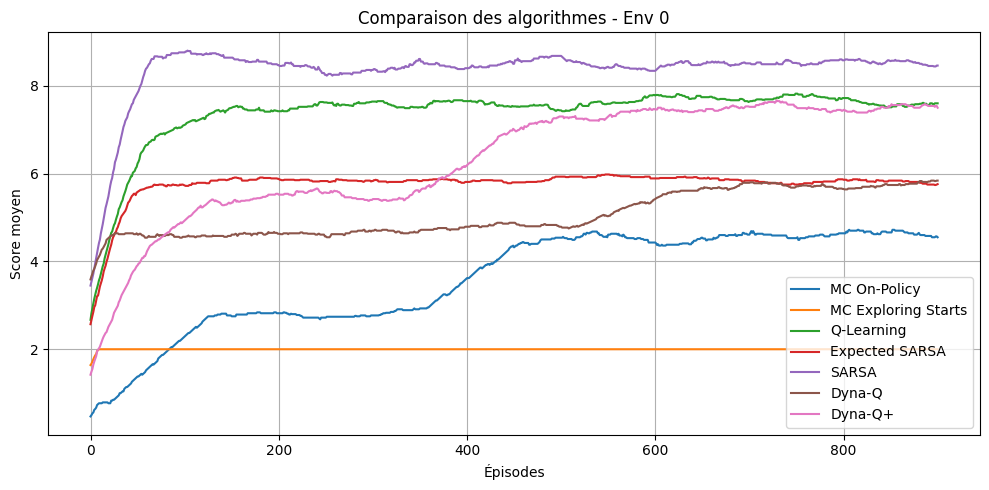

In [6]:
plt.figure(figsize=(10, 5))
# plt.plot(np.convolve(scores_mc_off_policy, np.ones(100)/100, mode='valid'), label="MC Off-Policy")
plt.plot(np.convolve(scores_mc_on_policy, np.ones(100)/100, mode='valid'), label="MC On-Policy")
plt.plot(np.convolve(scores_mc_exploring_starts, np.ones(100)/100, mode='valid'), label="MC Exploring Starts")
plt.plot(np.convolve(scores_q, np.ones(100)/100, mode='valid'), label="Q-Learning")
plt.plot(np.convolve(scores_esarsa, np.ones(100)/100, mode='valid'), label="Expected SARSA")
plt.plot(np.convolve(scores_sarsa, np.ones(100)/100, mode='valid'), label="SARSA")
plt.plot(np.convolve(scores_dq, np.ones(100)/100, mode='valid'), label="Dyna-Q")
plt.plot(np.convolve(scores_dqplus, np.ones(100)/100, mode='valid'), label="Dyna-Q+")
plt.title("Comparaison des algorithmes - Env 0")
plt.xlabel("Épisodes")
plt.ylabel("Score moyen")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation des résultats: 
Sur ce graphique, on observe l’évolution du score moyen obtenu par différents algorithmes de reinforcement learning au fil des épisodes, dans un environnement donné. Globalement, les meilleurs résultats sont atteints par l’algorithme SARSA, qui converge très rapidement vers un score élevé, supérieur à 8, et reste stable sur le long terme. Il est suivi de près par Q-Learning et Expected SARSA, qui eux aussi atteignent des performances solides autour de 7 à 7.5. Ces trois algorithmes montrent une capacité d’apprentissage efficace dans cet environnement.

D’autres approches comme Dyna-Q+ progressent plus lentement, mais finissent par rattraper une partie du retard en dépassant légèrement Expected SARSA, ce qui suggère un avantage dans des contextes où l’exploration sur le long terme est récompensée. En revanche, Dyna-Q reste en dessous, avec des scores moyens autour de 5.5, ce qui montre une performance correcte mais inférieure aux meilleurs.

Enfin, on remarque que l’algorithme MC On-Policy progresse très lentement et plafonne à un score relativement bas autour de 4. Quant à MC Exploring Starts, il stagne dès le début à un score fixe proche de 2, ce qui est anormal et laisse penser à un bug ou à une erreur dans son implémentation ou son évaluation.

Dans l’ensemble, ce graphique montre que les algorithmes off-policy (comme Q-Learning et SARSA) sont bien mieux adaptés à cet environnement que les approches Monte Carlo testées ici.  


### Étude sur l'environnement Env 1

In [7]:
env_name = "Env1"
env_class = SecretEnv1


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [06:16<00:00,  2.66it/s]


#### Comparaison graphique des performances

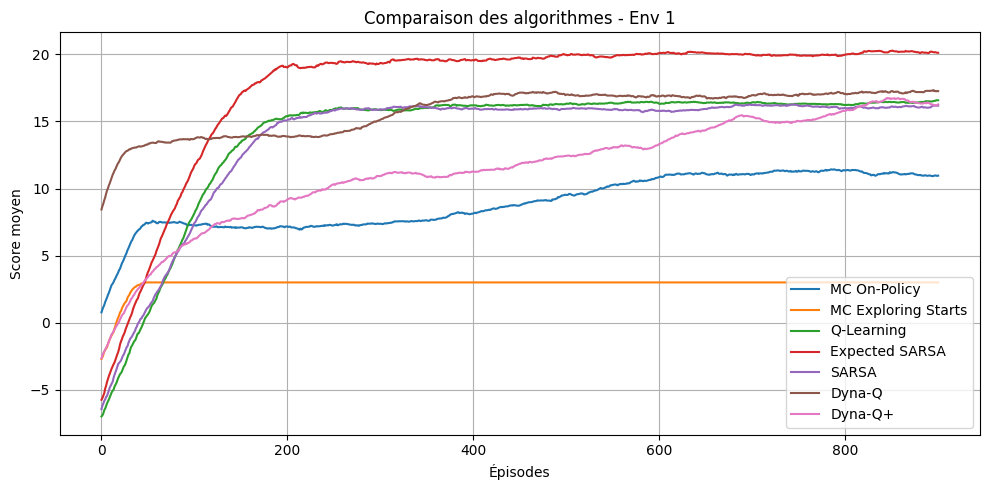

In [8]:
plt.figure(figsize=(10, 5))
# plt.plot(np.convolve(scores_mc_off_policy, np.ones(100)/100, mode='valid'), label="MC Off-Policy")
plt.plot(np.convolve(scores_mc_on_policy, np.ones(100)/100, mode='valid'), label="MC On-Policy")
plt.plot(np.convolve(scores_mc_exploring_starts, np.ones(100)/100, mode='valid'), label="MC Exploring Starts")
plt.plot(np.convolve(scores_q, np.ones(100)/100, mode='valid'), label="Q-Learning")
plt.plot(np.convolve(scores_esarsa, np.ones(100)/100, mode='valid'), label="Expected SARSA")
plt.plot(np.convolve(scores_sarsa, np.ones(100)/100, mode='valid'), label="SARSA")
plt.plot(np.convolve(scores_dq, np.ones(100)/100, mode='valid'), label="Dyna-Q")
plt.plot(np.convolve(scores_dqplus, np.ones(100)/100, mode='valid'), label="Dyna-Q+")
plt.title("Comparaison des algorithmes - Env 1")
plt.xlabel("Épisodes")
plt.ylabel("Score moyen")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Interpretation des résultats:

Dans cet environnement (Env 1), on observe une nette supériorité de l’algorithme Expected SARSA, qui atteint rapidement un score moyen proche de 20 et s’y stabilise sans fluctuation notable. Il surpasse l’ensemble des autres algorithmes, ce qui montre une excellente capacité à apprendre une politique efficace, probablement grâce à son compromis entre exploration et exploitation.

Les algorithmes Q-Learning, SARSA et Dyna-Q suivent avec des scores moyens stabilisés autour de 16, montrant également de bonnes performances mais légèrement inférieures. Cela indique qu’ils parviennent à apprendre des politiques efficaces, bien que moins optimales que celle d’Expected SARSA.

L’approche Dyna-Q+, conçue pour explorer davantage sur le long terme, affiche une progression plus lente mais régulière. Elle reste en dessous des performances des meilleurs algorithmes, avec un score qui finit autour de 15, ce qui montre une certaine efficacité mais aussi un possible manque d’adaptation dans cet environnement.

L’algorithme MC On-Policy montre une amélioration lente et un score final inférieur à 11, ce qui reste modeste. Enfin, MC Exploring Starts affiche une courbe plate à environ 3, comme dans le précédent environnement, suggérant à nouveau un dysfonctionnement dans son implémentation ou une inadaptation forte à ce type d’environnement.

En résumé, Expected SARSA est clairement le meilleur choix ici, suivi de Q-Learning, SARSA et Dyna-Q, tandis que les méthodes Monte Carlo testées sont peu efficaces voire défaillantes.


### Étude sur l'environnement Env 2

In [9]:
env_name = "Env2"
env_class = SecretEnv2


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [22:41<00:00,  1.36s/it]


#### Comparaison graphique des performances

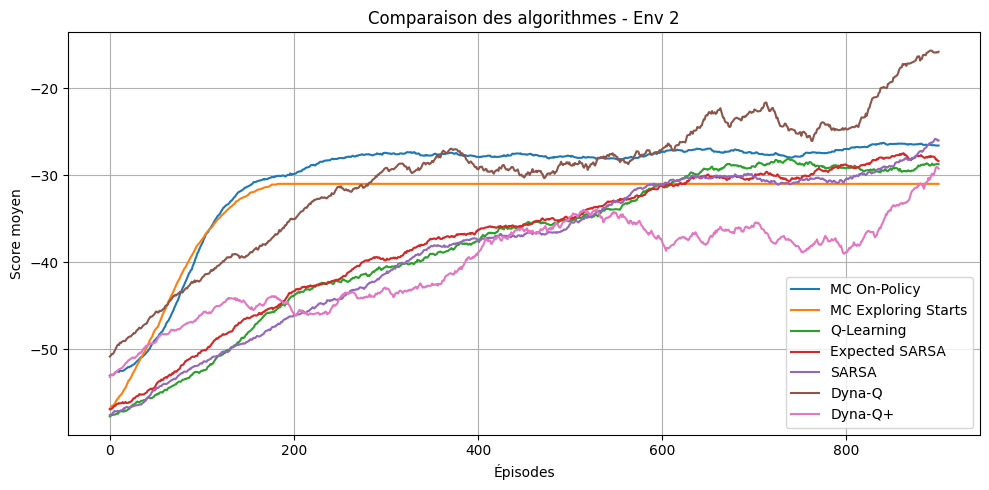

In [10]:
plt.figure(figsize=(10, 5))
# plt.plot(np.convolve(scores_mc_off_policy, np.ones(100)/100, mode='valid'), label="MC Off-Policy")
plt.plot(np.convolve(scores_mc_on_policy, np.ones(100)/100, mode='valid'), label="MC On-Policy")
plt.plot(np.convolve(scores_mc_exploring_starts, np.ones(100)/100, mode='valid'), label="MC Exploring Starts")
plt.plot(np.convolve(scores_q, np.ones(100)/100, mode='valid'), label="Q-Learning")
plt.plot(np.convolve(scores_esarsa, np.ones(100)/100, mode='valid'), label="Expected SARSA")
plt.plot(np.convolve(scores_sarsa, np.ones(100)/100, mode='valid'), label="SARSA")
plt.plot(np.convolve(scores_dq, np.ones(100)/100, mode='valid'), label="Dyna-Q")
plt.plot(np.convolve(scores_dqplus, np.ones(100)/100, mode='valid'), label="Dyna-Q+")
plt.title("Comparaison des algorithmes - Env 2")
plt.xlabel("Épisodes")
plt.ylabel("Score moyen")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Interprétation des résultats :

Dans cet environnement plus difficile (Env 2), l’ensemble des algorithmes commencent avec des scores très bas, autour de -55, ce qui reflète un environnement punitif ou complexe. Au fil des épisodes, plusieurs tendances se distinguent.

L’algorithme Dyna-Q montre une progression impressionnante : après un démarrage modeste, il parvient à dépasser tous les autres et atteint un score proche de -15, en constante amélioration. Cela suggère que sa capacité à combiner apprentissage direct et planification lui permet de mieux s’adapter à des dynamiques complexes.

Les algorithmes MC On-Policy et MC Exploring Starts atteignent des performances similaires, se stabilisant vers -30, avec une légère supériorité du premier. Malgré un environnement difficile, ils arrivent à tirer profit des trajectoires complètes, mais restent limités par l’exploration ou le caractère aléatoire de leurs mises à jour.

Les algorithmes Q-Learning, Expected SARSA et SARSA évoluent de façon quasi parallèle, convergeant autour de -32 à -30. Ils semblent moins performants ici que dans les environnements précédents, ce qui peut indiquer que l’instabilité ou la forte variabilité des récompenses affecte leur efficacité.

Enfin, Dyna-Q+, censé favoriser l’exploration à long terme, affiche des performances globalement faibles avec des fluctuations importantes, finissant au-dessus de -35 mais sans réelle stabilité. Cela laisse penser que son mécanisme bonus n’est pas assez bénéfique dans ce contexte, ou qu’il perturbe la convergence vers une bonne politique.

En résumé, Dyna-Q s’adapte remarquablement à cet environnement, tandis que la plupart des autres algorithmes atteignent des plateaux plus modestes, et que Dyna-Q+ peine à trouver un équilibre.

### Étude sur l'environnement Env 3

In [11]:
env_name = "Env3"
env_class = SecretEnv3


# MC Off-policy
# policy_mc_off_policy, Q_mc_off_policy, scores_mc_off_policy = run_experiment(
#     env_class, mc_off_policy_control, "Monte Carlo Off-Policy", env_name,
#     nb_episodes=100, gamma=0.99)

# MC On-policy First Visit
policy_mc_on_policy, Q_mc_on_policy, scores_mc_on_policy = run_experiment(
    env_class, mc_on_policy_first_visit, "Monte Carlo On-Policy First Visit", env_name,
    nb_episodes=1000, gamma=0.99, epsilon=0.01)

# MC Exploring Starts
policy_mc_exploring_starts, Q_mc_exploring_starts, scores_mc_exploring_starts = run_experiment(
    env_class, mc_exploring_starts, "Monte Carlo Exploring Starts", env_name,
    nb_episodes=1000, gamma=0.99)

# Q-learning
policy_q, Q_q, scores_q = run_experiment(
    env_class, q_learning, "Q-Learning", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Expected SARSA
policy_esarsa, Q_esarsa, scores_esarsa = run_experiment(
    env_class, expected_sarsa, "Expected SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# SARSA
policy_sarsa, Q_sarsa, scores_sarsa = run_experiment(
    env_class, sarsa, "SARSA", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01)

# Dyna-Q
policy_dq, Q_dq, scores_dq = run_experiment(
    env_class, dyna_q, "Dyna-Q", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20)

# Dyna-Q+
policy_dqplus, Q_dqplus, scores_dqplus = run_experiment(
    env_class, dyna_q_plus, "Dyna-Q+", env_name,
    nb_episodes=1000, gamma=0.99, alpha=0.1, epsilon=0.01, planning_steps=20, kappa=1e-4)

Dyna-Q+: 100%|██████████| 1000/1000 [33:10<00:00,  1.99s/it]


#### Comparaison graphique des performances

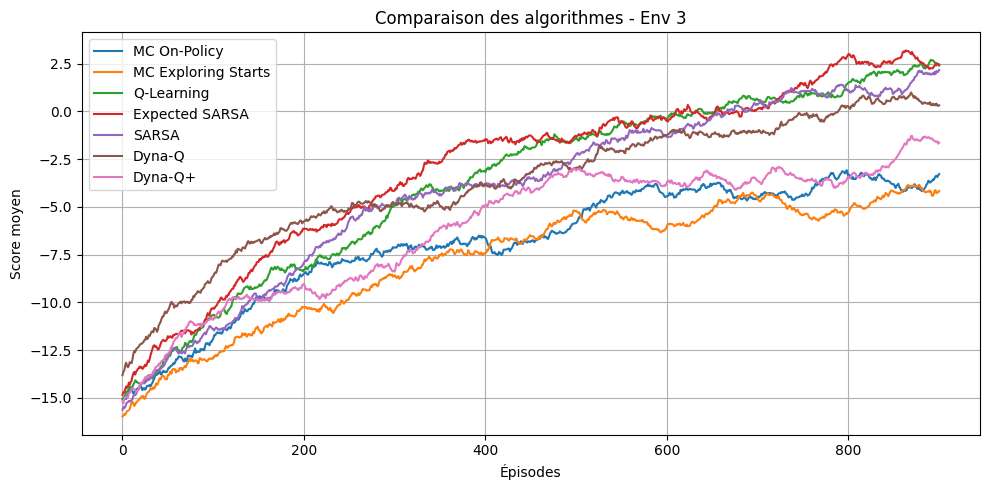

In [12]:
plt.figure(figsize=(10, 5))
# plt.plot(np.convolve(scores_mc_off_policy, np.ones(100)/100, mode='valid'), label="MC Off-Policy")
plt.plot(np.convolve(scores_mc_on_policy, np.ones(100)/100, mode='valid'), label="MC On-Policy")
plt.plot(np.convolve(scores_mc_exploring_starts, np.ones(100)/100, mode='valid'), label="MC Exploring Starts")
plt.plot(np.convolve(scores_q, np.ones(100)/100, mode='valid'), label="Q-Learning")
plt.plot(np.convolve(scores_esarsa, np.ones(100)/100, mode='valid'), label="Expected SARSA")
plt.plot(np.convolve(scores_sarsa, np.ones(100)/100, mode='valid'), label="SARSA")
plt.plot(np.convolve(scores_dq, np.ones(100)/100, mode='valid'), label="Dyna-Q")
plt.plot(np.convolve(scores_dqplus, np.ones(100)/100, mode='valid'), label="Dyna-Q+")
plt.title("Comparaison des algorithmes - Env 3")
plt.xlabel("Épisodes")
plt.ylabel("Score moyen")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Interprétation des résultats 
Dans cet environnement (Env 3), tous les algorithmes débutent avec des scores moyens très négatifs, proches de -15, indiquant un environnement initialement difficile à maîtriser. Cependant, à mesure que les épisodes progressent, on observe une amélioration généralisée des performances, bien que les vitesses et les plafonds de convergence diffèrent selon les méthodes.

Expected SARSA se distingue nettement, atteignant les meilleures performances finales avec un score moyen supérieur à +2.5, ce qui témoigne d’une grande stabilité et d’un bon compromis entre exploration et exploitation. Il est suivi de près par Q-Learning et SARSA, qui affichent tous deux une convergence régulière, avec des scores moyens légèrement supérieurs à 2.

Dyna-Q, après une montée rapide au début, plafonne en dessous de ces trois algorithmes, autour de 1.5, montrant qu’il est efficace mais peut-être moins optimal à long terme dans cet environnement. Quant à Dyna-Q+, il reste globalement sous-performant, oscillant autour de -2 malgré une tendance haussière vers la fin, ce qui suggère que sa stratégie d’exploration bonus n’est pas totalement adaptée à cet environnement.

Enfin, MC On-Policy et MC Exploring Starts restent les moins performants, avec des scores moyens qui stagnent autour de -4 à -5. Cela montre les limites des méthodes Monte Carlo dans des contextes où la complétion d’épisodes ou la variabilité des récompenses rendent l’apprentissage plus lent.

En résumé, Expected SARSA s’impose comme le meilleur compromis pour cet environnement, tandis que Q-Learning et SARSA montrent également de bonnes capacités d’adaptation.

In [ ]:
env_name = "Env0"
env_class = SecretEnv0

policy_pi, V_pi, _ = run_experiment(
    env_class, policy_iteration, "Policy Iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_pi = evaluate_policy_score(env_class(), policy_pi, nb_episodes=500)
summary_pi = summarize_policy_scores(scores_pi)
print("Policy Iteration summary:", summary_pi)


# Pour Value Iteration
policy_vi, V_vi, _ = run_experiment(
    env_class, value_iteration, "Value Iteration", env_name,
    gamma=0.99, theta=1e-6, max_iterations=1000)
scores_vi = evaluate_policy_score(env_class(), policy_vi, nb_episodes=500)
summary_vi = summarize_policy_scores(scores_vi)
print("Value Iteration summary:", summary_vi)

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(np.convolve(scores_mc_off_policy, np.ones(100)/100, mode='valid'), label="MC Off-Policy")
# plt.plot(np.convolve(scores_mc_on_policy, np.ones(100)/100, mode='valid'), label="MC On-Policy")
# plt.plot(np.convolve(scores_mc_exploring_starts, np.ones(100)/100, mode='valid'), label="MC Exploring Starts")
# plt.plot(np.convolve(scores_q, np.ones(100)/100, mode='valid'), label="Q-Learning")
# plt.plot(np.convolve(scores_esarsa, np.ones(100)/100, mode='valid'), label="Expected SARSA")
# plt.plot(np.convolve(scores_sarsa, np.ones(100)/100, mode='valid'), label="SARSA")
# plt.plot(np.convolve(scores_dq, np.ones(100)/100, mode='valid'), label="Dyna-Q")
# plt.plot(np.convolve(scores_dqplus, np.ones(100)/100, mode='valid'), label="Dyna-Q+")
plt.plot(np.convolve(scores_pi, np.ones(100)/100, mode='valid'), label="Policy Iteration")
plt.plot(np.convolve(scores_vi, np.ones(100)/100, mode='valid'), label="Value Iteration")
plt.title("Comparaison des algorithmes - Env 3")
plt.xlabel("Épisodes")
plt.ylabel("Score moyen")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()